# Trend-following (or Time Series Momentum) Signals

#### by Gustavo Soares

In this notebook you will apply a few things you learned in the [FinanceHub's Python lectures](https://github.com/Finance-Hub/FinanceHubMaterials/tree/master/Python%20Lectures):

* You will use and manipulate different kinds of variables in Python such as text variables, booleans, floats, dictionaries, lists, etc.;
* We will also use `Pandas.DataFrame` objects and methods which are very useful in manipulating financial time series;
* You will use if statements, loops, and list comprehensions, and;
* You will use [FinanceHub's Bloomberg tools](https://github.com/Finance-Hub/FinanceHub/tree/master/bloomberg) for fetching data from a [Bloomberg terminal](https://data.bloomberglp.com/professional/sites/10/LUISS_2018Primer.pdf). If you are using this notebook within BQuant (or BQNT), you may want to use BQL for getting the data.


## Introduction

Trend-following is one of the most prevalent quantitative strategies and it applies to several markets such as equity indices, currencies, and futures markets such as commodities and bond futures. Trend-following (TF) or Time Series Momentum (TSM) refers to the predictability of the past returns on future returns and is the focus of several influential studies. The best overall academic summary of trend-following can be found on in the paper [Moskowitz, Ooi, and Pedersen (2012)](https://doi.org/10.1016/j.jfineco.2011.11.003) where the authors document significant momentum in monthly returns. There they find strongest results for relatively short holdings periods (1 or 3 months) and mid-range lookback periods such as (9 and 12 months).

There are several ways of identifying trends. The two most comon ones are time series momentum (past excess returns) and moving average crossovers. [Levine and Pedersen (2015)](https://ssrn.com/abstract=2603731) show both measures are closely connected. In fact, they are equivalent representations in their most general forms, and they also capture many other types of filters such as the HP filter, the Kalman filter, and all other linear filters. If we think of the log-price of asset $i$ in period $t$ as $p_{i,t}$, they show that trend indicators can be generally understood as:

$$
TSMOM_{i,t} = \sum_{s=1}^{\infty} c_{s}(p_{i,t-s+1} - p_{i,t-s})
$$

where $c_{s}$ is a set of weights. For instance, one might use $c_{s}$ to weigh more recent price changes in assessing the current price trend and even allow for reversals in some frequencies with negative weights.

In the section, [Momentum signals](#signals) below we discuss commonly used momentum signals.

## Before we start: *import Python packages and upload tracker time series data*

Before we get started, let's import some Python packages we are going to need. Also, let's upload time series data that has been properly constructed to reflect the cumulative excess returns of underlying asssets. If you are not quite sure what that means, check out or materials on constructing **tracker** time series for financial time series for trading [currencies](https://github.com/Finance-Hub/FinanceHubMaterials/blob/master/Quantitative%20Finance%20Lectures/creating_fx_time_series_fh.ipynb), [futures](https://github.com/Finance-Hub/FinanceHubMaterials/blob/master/Quantitative%20Finance%20Lectures/rolling_futures_time_series.ipynb), and [interest rates swaps](https://github.com/Finance-Hub/FinanceHubMaterials/blob/master/Quantitative%20Finance%20Lectures/swap_historical_returns.ipynb)!

Our tracker data consists of 112 financial time series. Each one of them starts at a different date. The largest time series has 5350 data points and the shortest one has only 1736 datapoints. The first column of the file is the date column and we will use that as the dataframe index:

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline
tracker_data = pd.read_csv('set_of_trackers.csv',index_col=0)

## Momentum signals <a id="signals"></a>

##### Classic momentum

The classic definition of momentum is simply the percentage change in the financial time series over $h$ time periods. Sometimes, this classic definition is calculated by looking at log-percentage changes by calculating the the difference between the log of today's price vs. the log of the price $h$ periods ago.

The function below calculates these two types of classic momentum:

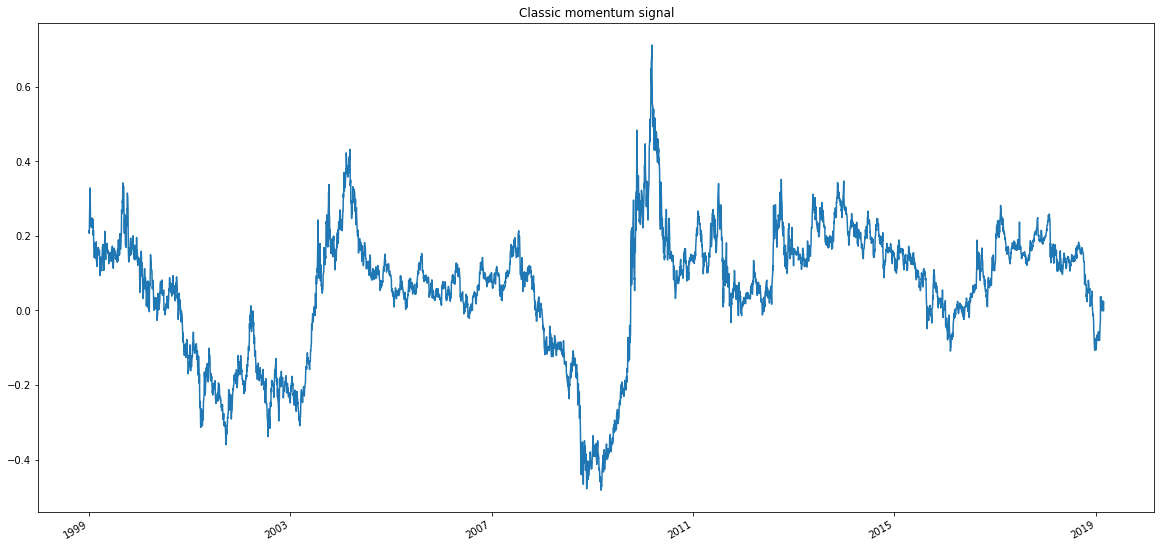

In [2]:
def momentum(ts, h=252, signal_type='classic'):
    df = ts.astype(float).shift(1)  # note the day lag!!
    df.index = pd.to_datetime(df.index)
    if signal_type=='classic_log':
        df_mom = np.log(df).diff(h)
    else:
        if signal_type != 'classic':
            print('Momentum signal type was not recognized! assuming default')            
        df_mom = df.pct_change(h)
    return df_mom

ts = tracker_data.iloc[:,0]
mom = momentum(ts, h=252, signal_type='classic')
mom.plot(title='Classic momentum signal',figsize=(20,10))
plt.show()

##### Momentum in equities: twelve-minus-one momentum

In equities, the classic momentum measure is typically a bit different. There is empricial evidence (e.g., [Jagadeesh and Titman (1993)]) that short-term momentum actually has a reversal affect, whereby the previous winners (measured over the past period) do poorly the next period, while the previous losers (measured over the past period) do well the next month. Most academic papers in equities ignore the previous period return in the momentum calculation even though it only has a marginal affect on the performance of momentum strategies. Here, we do not apply the last period "drop" but you should know this is how momentum is defined by defined in equities such as in [Kenneth French's Data Library](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html).

Just for completion, let's add that definition to our momentum function as signal type *classic_minus_1*:

In [3]:
def momentum(ts, h=252, signal_type='classic'):
    df = ts.astype(float).shift(1)  # note the day lag!!
    df.index = pd.to_datetime(df.index)
    if signal_type=='classic_log':
        df_mom = np.log(df).diff(h)
    elif signal_type=='classic_minus_1':
        df_mom = np.log(df).diff(h).shift(21)
    else:
        if signal_type != 'classic':
            print('Momentum signal type was not recognized! assuming default')            
        df_mom = df.pct_change(h)
    return df_mom

##### Volatility adjustment

Since volatility varies across assets, it is common for momentum signals to be *volatility adjusted*, i.e., for momentum signals to be scaled at each point in time by some measure of *ex-ante* volatility. For example, [Moskowitz, Ooi, and Pedersen (2012)](https://doi.org/10.1016/j.jfineco.2011.11.003) use the lagged 60-days half-life EWMA on squared daily returns to run their regression analysis. As discussed in **Designing robust trend-following systems** by the Global Quantitative & Derivatives Strategy from JP Morgan, this also allows us to interpret the signal as a statistical test whether the mean return of an asset is either positive or negative, i.e., a *t-test*.

Of course, the volatility adjustment depends crucially on the volatility measure used.

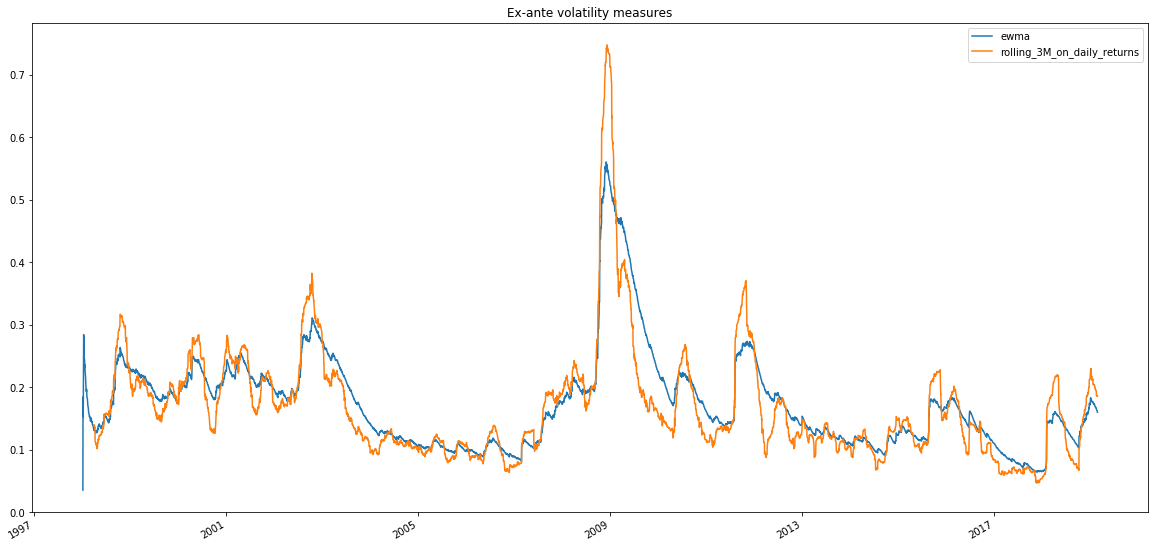

In [4]:
def get_lagged_vol(ts, h=21, vol_type='ewma', min_vol_window=756, halflife=60):
    # clean up
    lagged_data = ts.astype(float).shift(1)  # note the day lag!!
    lagged_data.index = pd.DatetimeIndex(pd.to_datetime(lagged_data.index))
    if vol_type == 'ewma': # From Moskowitz, Ooi, and Pedersen (2012) and roughly similar to a GARCH(1, 1) model        
        vols = np.sqrt(((np.log(lagged_data).diff(1)**2).ewm(halflife=halflife).mean())*252)
    else:
        if vol_type != 'rolling':
            print('vol_type not recognized, assuming rolling window of %s bdays over %s bday returns' % (min_vol_window,h))
        vols = np.log(lagged_data).diff(h).rolling(window=min_vol_window).std()*np.sqrt(252/h)
    return vols

ts = tracker_data.iloc[:,0]
ewma_vol = get_lagged_vol(ts)
rolling_vol = get_lagged_vol(ts,h=1,vol_type='rolling',min_vol_window=(3*21))

pd.concat([ewma_vol.to_frame('ewma'),rolling_vol.to_frame('rolling_3M_on_daily_returns')]
                      ,axis=1,sort=True).plot(title='Ex-ante volatility measures',figsize=(20,10))
plt.show()

Let's add the option of volatility adjusting our momentum signal to our momentum function:

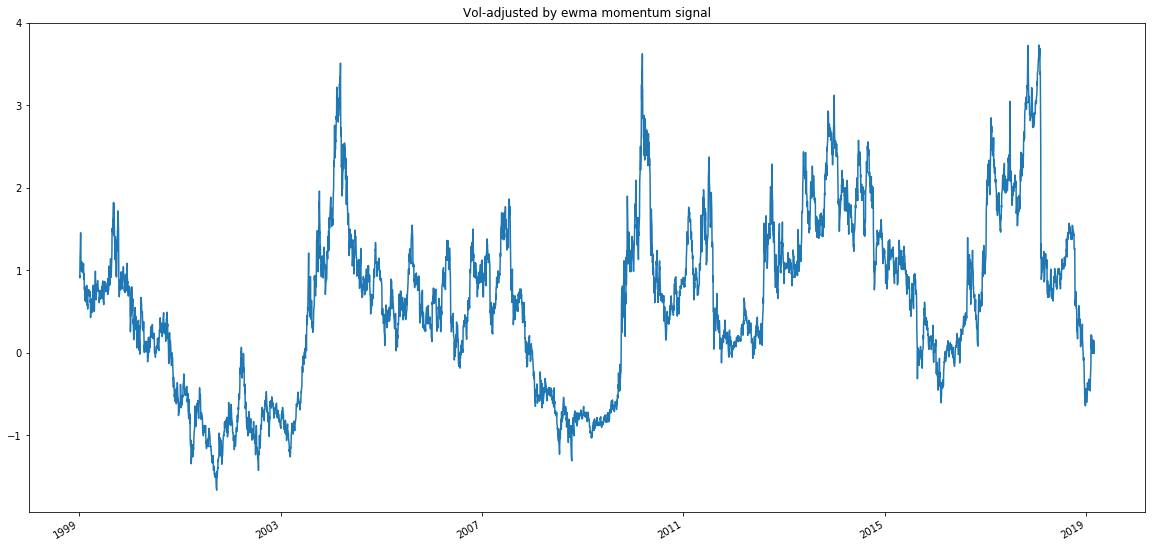

In [5]:
def momentum(ts, h=252, signal_type='classic', vol_adjust=False):
    df = ts.astype(float).shift(1)  # note the day lag!!
    df.index = pd.to_datetime(df.index)
    if signal_type=='classic_log':
        df_mom = np.log(df).diff(h)
    elif signal_type=='classic_minus_1':
        df_mom = np.log(df).diff(h).shift(21)
    else:
        if signal_type != 'classic':
            print('Momentum signal type was not recognized! assuming default')            
        df_mom = df.pct_change(h)
    
    if vol_adjust: # this will be true whethere the parameter vol_adjust is a boolean equal to True or if it's a string        
        if isinstance(vol_adjust,bool): # check if boolean
            vols = get_lagged_vol(ts)                            
        else:
            vols = get_lagged_vol(ts,vol_type=vol_adjust)                                    
        return df_mom/vols
    else:                
        return df_mom
ts = tracker_data.iloc[:,0]    
vol_adjusted_mom = momentum(ts, h=252, signal_type='classic',vol_adjust=True)
vol_adjusted_mom.plot(title='Vol-adjusted by ewma momentum signal',figsize=(20,10))
plt.show()

##### Momentum signal based on the t-stat's p-value

If we can interpret the momentum signal adjusted by volatility as a *t-test* then, following **Designing robust trend-following systems** by the Global Quantitative & Derivatives Strategy from JP Morgan, we can map the final signal to the strength of the *p-value* of the t-test. The authors suggest using the cdf of the standard normal distribution $\Phi$:

$$S_{i,t}(W) = 2 \times \Phi (MOM_{t}) - 1$$

to normalize the signal to be in between -1 and 1, making signal calculations more evolved.

In addition to the p-value strength interpretation of the singal there we can also interpret it as the delta of a straddle with specific input parameters. See also [Fung and Hsieh (2001)](https://faculty.fuqua.duke.edu/~dah7/RFS2001.pdf) for a classic referce on the connection between the PnL drivers of a ‘delta-hedged straddle’ and trend-following strategies.

Let's add the *p-value* case to our momentum function:

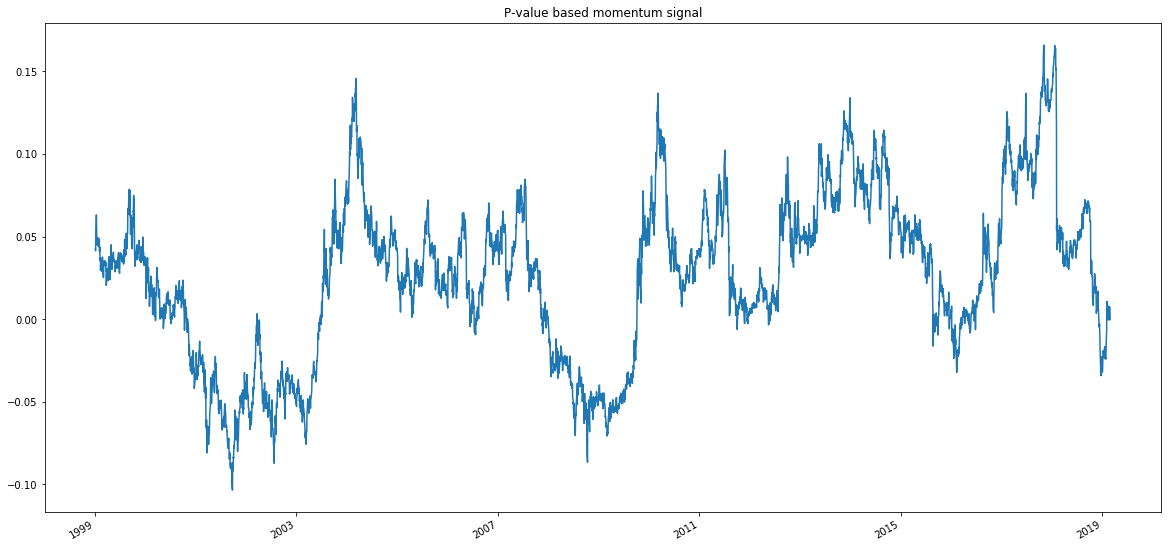

In [6]:
def momentum(ts, h=252, signal_type='classic', vol_adjust=False):
    df = ts.astype(float).shift(1)  # note the day lag!!
    df.index = pd.to_datetime(df.index)
    if signal_type=='classic_log':
        df_mom = np.log(df).diff(h)
        
    elif signal_type=='classic_minus_1':        
        df_mom = np.log(df).diff(h).shift(21)
        
    elif signal_type=='p_value':
        rets = np.log(df).diff(h)
        vols = get_lagged_vol(ts)                            
        ttest = (((rets/h) * np.sqrt(252))/vols).dropna()
        df_mom = pd.Series(index=ttest.index,data=(2*norm.cdf(ttest)- 1))  # this normalizes the signal to be in between [-1,1]
        
    else:
        if signal_type != 'classic':
            print('Momentum signal type was not recognized! assuming default')            
        df_mom = df.pct_change(h)
    
    if vol_adjust: # this will be true whethere the parameter vol_adjust is a boolean equal to True or if it's a string        
        if isinstance(vol_adjust,bool): # check if boolean
            vols = get_lagged_vol(ts)                            
        else:
            vols = get_lagged_vol(ts,vol_type=vol_adjust)                                    
        return df_mom/vols
    else:                
        return df_mom
ts = tracker_data.iloc[:,0]
mom = momentum(ts, h=252, signal_type='p_value')
mom.plot(title='P-value based momentum signal',figsize=(20,10))
plt.show()

##### Moving average convergence/divergence (MACD) indicator

Moving average convergence/divergence (MACD), is a trading indicator used in technical analysis designed to reveal changes in the strength, direction, momentum, and duration of a trend. The MACD signal is the difference between a "fast" (short period, typically, 10 or 12 days) exponential moving average (EMA), and a "slow" (longer period, typically, 21 or 26 days) EMA of the price series.

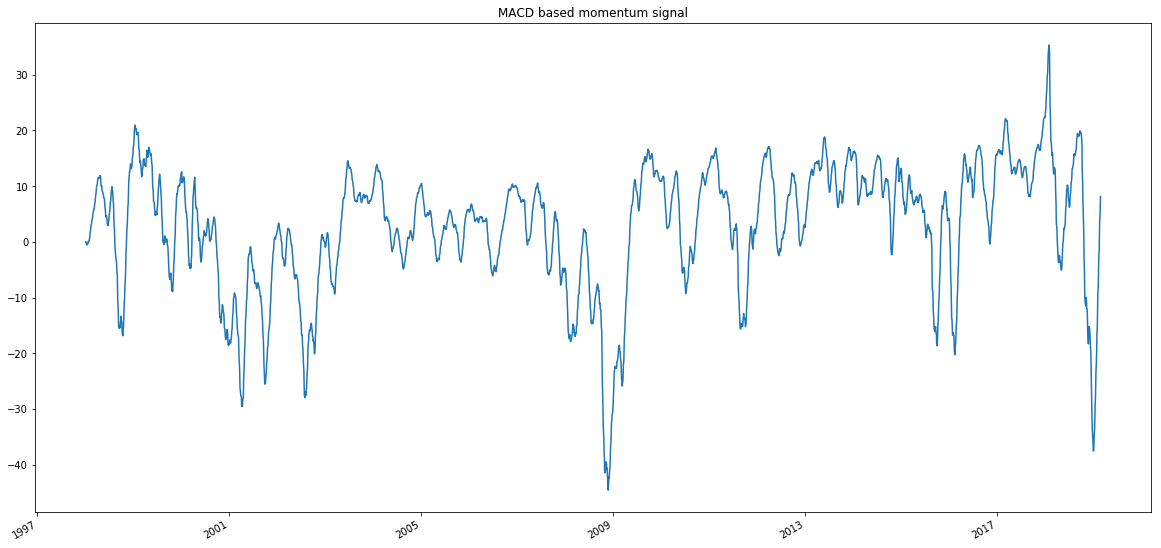

In [7]:
def momentum(ts, h=252, signal_type='classic', vol_adjust=False):
    df = ts.astype(float).shift(1)  # note the day lag!!
    df.index = pd.to_datetime(df.index)
    if signal_type=='classic_log':
        df_mom = np.log(df).diff(h)        
    elif signal_type=='classic_minus_1':        
        df_mom = np.log(df).diff(h).shift(21)
    elif signal_type=='macd':
        df_rap = df.ewm(halflife=12).mean()
        df_len = df.ewm(halflife=26).mean()
        df_mom = df_rap - df_len        
    elif signal_type=='p_value':
        rets = np.log(df).diff(h)
        vols = get_lagged_vol(ts)                            
        ttest = (((rets/h) * np.sqrt(252))/vols).dropna()
        df_mom = pd.Series(index=ttest.index,data=(2*norm.cdf(ttest)- 1))  # this normalizes the signal to be in between [-1,1]        
    else:
        if signal_type != 'classic':
            print('Momentum signal type was not recognized! assuming default')            
        df_mom = df.pct_change(h)
    
    if vol_adjust: # this will be true whethere the parameter vol_adjust is a boolean equal to True or if it's a string        
        if isinstance(vol_adjust,bool): # check if boolean
            vols = get_lagged_vol(ts)                            
        else:
            vols = get_lagged_vol(ts,vol_type=vol_adjust)                                    
        return df_mom/vols
    else:                
        return df_mom
ts = tracker_data.iloc[:,0]
mom = momentum(ts, h=252, signal_type='macd')
mom.plot(title='MACD based momentum signal',figsize=(20,10))
plt.show()

##### Relative Strenght Index (RSI)

The relative strength index (RSI) is a technical indicator of momentum as well. Up periods are characterized by the close being higher than the previous close. Conversely, a down period is characterized by the close being lower than the previous period's close. Hence, for each date $t$, we calculate the change $\Delta y_{t}$ in the series and calculate:

$$
U_{t} = \Delta y_{t} \text{ if } \Delta y_{t} >0 \text{ and } 0 \text{ otherwise }
$$
$$
D_{t} = \Delta y_{t} \text{ if } \Delta y_{t} <0 \text{ and } 0 \text{ otherwise }
$$

and therefore $\overline{U}_{n,t} \equiv n^{-1} \times \sum_{s=1}^{n} U_{t-s}$ is the average of upward moves and $\overline{D}_{n,t} \equiv n^{-1} \times \sum_{s=1}^{n} D_{t-s}$ is the average of downward changes calculated (these average are sometimes replaced by EWMA averages).

The ratio of these averages is the relative strength or relative strength factor $RS_{n,t} \equiv \overline{U}_{n,t} / \overline{D}_{n,t}$ and the Relative Strenght Index (RSI) is calculated as:

$$
RSI_{n,t} \equiv 100-{100 \over {1+RS_{n,t}}}
$$

If the average of *down* values declines/increases vs. the average of *up* values, then $RSI_{n,t}$ will increase/decrease indicating positive/negative momentum. In the limits, if the average of *down* values approaches zero, $RSI_{n,t}$ will converge to 100 and as the average of *up* values approaches zero, $RSI_{n,t}$ will converge to zero.

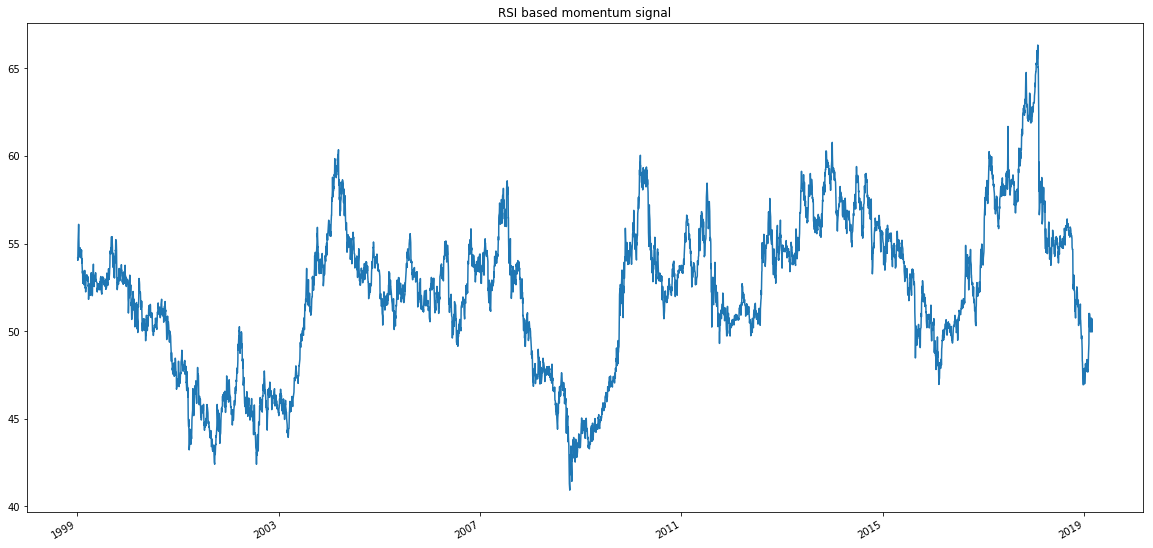

In [8]:
def momentum(ts, h=252, signal_type='classic', vol_adjust=False):
    df = ts.astype(float).shift(1)  # note the day lag!!
    df.index = pd.to_datetime(df.index)
    if signal_type=='classic_log':
        df_mom = np.log(df).diff(h)        
    elif signal_type=='classic_minus_1':        
        df_mom = np.log(df).diff(h).shift(21)
    elif signal_type=='macd':
        df_rap = df.ewm(halflife=12).mean()
        df_len = df.ewm(halflife=26).mean()
        df_mom = df_rap - df_len        
    elif signal_type=='p_value':
        rets = np.log(df).diff(h)
        vols = get_lagged_vol(ts)                            
        ttest = (((rets/h) * np.sqrt(252))/vols).dropna()
        df_mom = pd.Series(index=ttest.index,data=(2*norm.cdf(ttest)- 1))  # this normalizes the signal to be in between [-1,1]
    elif signal_type=='rsi':
        df_delta = df.diff().dropna()    
        up, down = df_delta.copy(), df_delta.copy()
        up[up < 0] = 0
        down[down > 0] = 0
        roll_up1 = up.rolling(h).sum()
        roll_down1 = down.rolling(h).sum().abs()
        df_rs = roll_up1 / roll_down1
        df_mom = 100 - 100 / (1 + df_rs)        
    else:
        if signal_type != 'classic':
            print('Momentum signal type was not recognized! assuming default')            
        df_mom = df.pct_change(h)
    
    if vol_adjust: # this will be true whethere the parameter vol_adjust is a boolean equal to True or if it's a string        
        if isinstance(vol_adjust,bool): # check if boolean
            vols = get_lagged_vol(ts)                            
        else:
            vols = get_lagged_vol(ts,vol_type=vol_adjust)                                    
        return df_mom/vols
    else:                
        return df_mom
ts = tracker_data.iloc[:,0]
mom = momentum(ts, h=252, signal_type='rsi')
mom.plot(title='RSI based momentum signal',figsize=(20,10))
plt.show()

## Exercises

#### Beginners

Try to calculate for all tracker in the tracker dataset and create some code to run some regressions like regression (2) and (3) in [Moskowitz, Ooi, and Pedersen (2012)](https://doi.org/10.1016/j.jfineco.2011.11.003) and see what momentum signal has the best overall fit. Also, think about the case where the momentum signal is only supposed to predict direction (so if the underlying is going up or down) and not predict the actual realized future returns.

#### Intermediate

Calculate the time series momentum factor from [Moskowitz, Ooi, and Pedersen (2012)](https://doi.org/10.1016/j.jfineco.2011.11.003) for the tracker dataset using different momentum signals defined above and compare them in terms of *accuracy*, *precision*, and *recall** as defined by:

$$
Accuracy = (TP+TN)/(TP+FP+FN+TN) \\
Precision = (TP)/(TP+FP) \\
Recall = (TP)/(TP+FN)
$$

where

* $TP$ is the number of *true positives*, i.e., the number of times the signal predicted positive returns and it was right;
* $TN$ is the number of *true negatives*, i.e., the number of times the signal predicted negative returns and it was right;
* $FP$ is the number of *false positives*, i.e., the number of times the signal predicted positive returns and it was wrong, and
* $FN$ is the number of *false negatives*, i.e., the number of times the signal predicted negative returns and it was wrong.


#### Intermediate

The momentum() and get_lagged_vol() functions created above depend heavily on the input being a `Pandas` object. Change the function to cope with `Numpy` arrays and compare the speed of the two implementations.

#### Advanced

Carry out the generalization mentioned in the Intermediate task above (or other improvemente you may see fit) and create a tsmom class with appropriate methods (e.g., momentum() and get_lagged_vol() functions above.

#### Jedi Master

Carry out the Advanced taske above and make a contribution to [FinanceHub's signals class](https://github.com/Finance-Hub/FinanceHub/tree/master/signals) by replacing the existing tsmom_class.py file with your new, better, faster, and more general class.